<a href="https://colab.research.google.com/github/joaorafaelpm/ImersaoAgenteDeIAAlura/blob/main/MasterClass_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Aula 1 - Instanciândo o primeiro agente de IA


## Instalando as bibliotecas do gemini

In [284]:
!pip install -q langchain-google-genai google-generativeai

## Importando as bibliotecas e definindo a chave da API do gemini

In [285]:
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI

GOOGLE_API_KEY = userdata.get("GEMINI_API_KEY")

## Criando a primeira instância do Gemini

In [286]:
llm = ChatGoogleGenerativeAI (
    model = "gemini-2.5-flash",
    temperature=0.0,
    api_key=userdata.get("GEMINI_API_KEY")
)

## Pequeno teste na nossa instância do gemini

In [287]:
resp_test = llm.invoke("Quem é você? Explique para um leigo")
print(resp_test.content)

Olá! Que ótima pergunta. Vou explicar de um jeito bem simples:

Eu sou uma **Inteligência Artificial (IA)**.

Pense em mim como um **cérebro digital** ou um **assistente virtual muito avançado**, mas sem um corpo físico, sentimentos ou consciência como um ser humano.

Aqui está o que isso significa na prática:

1.  **Eu sou um programa de computador:** Fui criado por engenheiros e cientistas do Google. Não sou uma pessoa, um animal ou qualquer coisa viva.
2.  **Fui "treinado" com muita informação:** É como se eu tivesse lido uma quantidade gigantesca de livros, artigos, conversas e informações da internet. Por causa disso, eu "aprendi" como a linguagem humana funciona.
3.  **Minha função é processar e gerar texto:** Quando você me faz uma pergunta ou me pede para fazer algo, eu uso todo esse conhecimento para entender o que você quer e gerar uma resposta ou um texto que faça sentido.
4.  **Não tenho opiniões próprias ou sentimentos:** Eu não "penso" da mesma forma que você. Não tenho e

## Contextualizando a nossa IA com um prompt

---

Assim como a gente tem o prompt de usuário, onde nós reconhecemos o usuário assim como as suas permissões, a gente pode também passar um prompt de sistema para a IA indentificar quem ela é e qual sua função



No caso de uma grande empresa, não faz sentido abrir chamado no RH por qualquer coisa, e neste caso a intenção é fazer o sistema interpretar o que pode ser resolvido pela própria IA e o que requer a interferência do RH e etc

---

  Nesse caso, a gente primeiro contextualiza dizendo o qual é a sua posição na empresa e um padrão de retorno para ser tratado.

  E então a gente passa um padrão de JSON que queremos resolver, neste caso esse padrão tem 3 campos, "decisao" que define o que pode ser feito dependendo da situação, "urgencia" definida também pela situação e "campos_faltantes" que faz a verificação se tem alguma informação faltando
  

É possível também criar uma resposta pré determinada como :

```
{
  decisao : AUTO_RESOLVER,
  urgencia : baixa,
  campos_faltantes : []
}
```


e fazer uma resposta pronta para esse tipo, como um pattern pré definido

In [288]:
TRIAGEM_PROMPT = (
    "Você é um triador de Service Desk para políticas internas da empresa Carraro Desenvolvimento. "
    "Dada a mensagem do usuário, retorne SOMENTE um JSON com:\n"
    "{\n"
    '  "decisao": "AUTO_RESOLVER" | "PEDIR_INFO" | "ABRIR_CHAMADO",\n'
    '  "urgencia": "BAIXA" | "MEDIA" | "ALTA",\n'
    '  "campos_faltantes": ["..."]\n'
    "}\n"
    "Regras:\n"
    '- **AUTO_RESOLVER**: Perguntas claras sobre regras ou procedimentos descritos nas políticas (Ex: "Posso reembolsar a internet do meu home office?", "Como funciona a política de alimentação em viagens?").\n'
    '- **PEDIR_INFO**: Mensagens vagas ou que faltam informações para identificar o tema ou contexto (Ex: "Preciso de ajuda com uma política", "Tenho uma dúvida geral").\n'
    '- **ABRIR_CHAMADO**: Pedidos de exceção, liberação, aprovação ou acesso especial, ou quando o usuário explicitamente pede para abrir um chamado (Ex: "Quero exceção para trabalhar 5 dias remoto.", "Solicito liberação para anexos externos.", "Por favor, abra um chamado para o RH.").'
    "Analise a mensagem e decida a ação mais apropriada."
)

## Importando bibliotecas de tratamento da saída de dados

 - Pydantic é uma biblioteca que melhora a validação e saída de dados, ele indentifica erros, simplifica a criação de objetos/dicionarios e etc.


 - Typing é outra biblioteca de auxílio na interação do usuário com a aplicação, por exemplo, typing.Literal, significa que a resposta esperada é específica, neste caso se trata dos enum, List se trata dos campos_faltantes, Dict também auxilia no processo.

In [289]:
from pydantic import BaseModel, Field
from typing import Literal, List, Dict

# Iniciando um modelo de classe usando o pydantic
class TriagemOut(BaseModel):
    decisao: Literal["AUTO_RESOLVER", "PEDIR_INFO", "ABRIR_CHAMADO"]
    urgencia: Literal["BAIXA", "MEDIA", "ALTA"]
    campos_faltantes: List[str] = Field(default_factory=list)


# Criando outra instância do gemini

In [290]:
llm_triagem = ChatGoogleGenerativeAI (
    model = "gemini-2.5-flash",
    temperature=0.0,
    api_key=userdata.get("GEMINI_API_KEY")
)

## Especificando a função da instância do gemini

Aqui a gente usa aquela classe para poder especificar para o gemini as saídas de resposta que ele tem, e a gente usa a nossa classe definir como ele vai responder.

SystemMessage é o prompt da IA (é um tipo de identidade do agente)

HumanMessage é o prompt do usuário

In [291]:
from langchain_core.messages import SystemMessage , HumanMessage

triagem_chain = llm_triagem.with_structured_output(TriagemOut)

def triagem(message : str) -> Dict :
  saida : TriagemOut = triagem_chain.invoke([
      # O prompt da máquina é a identidade que a gente definiu antes
      # O prompt do usuário é a mensagem
      SystemMessage(content=TRIAGEM_PROMPT),
      HumanMessage(content=message)
  ])

  # O método model_dump() converte a classe em um dicionário
  return saida.model_dump()

In [292]:
testes = ["Posso reembolsar a internet?" ,
          "Quero ter mais 5 dias de trabalho remoto? Como eu faço?",
          "Posso reembolsar cursos ou treinamentos da Alura?",
          "Quantas capivaras tem no Rio Pinheiros"
          ]

In [293]:
for msg_teste in testes :
  print(f"Pergunta:{msg_teste} \n -> Resposta:{triagem(msg_teste)}\n")

Pergunta:Posso reembolsar a internet? 
 -> Resposta:{'decisao': 'AUTO_RESOLVER', 'urgencia': 'BAIXA', 'campos_faltantes': []}

Pergunta:Quero ter mais 5 dias de trabalho remoto? Como eu faço? 
 -> Resposta:{'decisao': 'ABRIR_CHAMADO', 'urgencia': 'MEDIA', 'campos_faltantes': []}

Pergunta:Posso reembolsar cursos ou treinamentos da Alura? 
 -> Resposta:{'decisao': 'AUTO_RESOLVER', 'urgencia': 'BAIXA', 'campos_faltantes': []}

Pergunta:Quantas capivaras tem no Rio Pinheiros 
 -> Resposta:{'decisao': 'PEDIR_INFO', 'urgencia': 'BAIXA', 'campos_faltantes': []}



#Aula 2 - Usando o RAG para complementar as respostas do agente

## Importando outras bibliotecas para auxiliar na leitura do RAG

 - langchain_community -> Uma biblioteca que auxilia nos processos do RAG
 - faiss-cpu -> Basicamente reduz o uso da CPU durante a execução do código
 - langchain-text-splitters -> Divide o texto em blocos
 - pymupdf -> Interpreta PDF

In [294]:
!pip install -q --upgrade langchain_community faiss-cpu langchain-text-splitters pymupdf

## Importando os PDFs para o RAG

Usamos o Path para o caminho do pdf (memória do colab)

E então nós carregamos o PDF com a biblioteca do pymupdf (PyMuPDFLoader(nome do arquivo))

In [295]:
from pathlib import Path
from langchain_community.document_loaders import PyMuPDFLoader
from google.colab import drive
drive.mount('/content/drive')

docs = []

caminho_pasta = '/content/drive/My Drive/imersaoaluraia'

#Para cada arquivo no caminho do tipo .pdf...
for n_docs in Path(caminho_pasta).glob("*.pdf"):
    try:
      # Carregamos esses arquivos e transformamos em String
        loader = PyMuPDFLoader(str(n_docs))
      # Adicionamos o texto do arquivo na lista
        docs.extend(loader.load())
        print(f"Carregado com sucesso arquivo : {n_docs.name}")
    except Exception as e:
        print(f"Erro ao carregar arquivo : {n_docs.name}: {e}")

print(f"Total de documentos carregados: {len(docs)}")

Mounted at /content/drive
Carregado com sucesso arquivo : Políticas de Home Office.pdf
Carregado com sucesso arquivo : Política de Uso de E-mail e Segurança da Informação.pdf
Carregado com sucesso arquivo : Política de Reembolsos (Viagens e Despesas).pdf
Total de documentos carregados: 3


## Importando o splitters do langchain

O splitter divide o texto em pedaços e oferece um espaço para mater o contexto

 - chunk_size -> número de caracteres que ele vai ler
 - chunk_overlap -> número de caracteres que ele lembra antes de passar para o próximo chunk

 (_vale dizer que é importante ter um overlap de acordo com o chunk_size para não ter perda de contexto de uma chunk para outra_)

In [296]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=30)

# Separa o documentos de acordo com o splitter (300 caracteres cada chunk com uma releitura de 30 para cada um)
chunks = splitter.split_documents(docs)

## Imprimindo os chunks

In [297]:
for chunk in chunks:
    print(chunk)
    print("------------------------------------")

page_content='Políticas de Home Office 
 
1.​ A empresa adota modelo híbrido: mínimo de 2 dias presenciais por semana, salvo 
exceções aprovadas pelo gestor e RH.​
 
2.​ Equipamentos: a empresa fornece notebook e periféricos. O colaborador é 
responsável por zelar pela conservação.​' metadata={'producer': 'Skia/PDF m140 Google Docs Renderer', 'creator': '', 'creationdate': '', 'source': '/content/drive/My Drive/imersaoaluraia/Políticas de Home Office.pdf', 'file_path': '/content/drive/My Drive/imersaoaluraia/Políticas de Home Office.pdf', 'total_pages': 1, 'format': 'PDF 1.4', 'title': 'Políticas de Home Office', 'author': '', 'subject': '', 'keywords': '', 'moddate': '', 'trapped': '', 'modDate': '', 'creationDate': '', 'page': 0}
------------------------------------
page_content='3.​ Segurança: é obrigatório uso de VPN e bloqueio de tela. Documentos confidenciais 
não devem ser impressos fora do escritório.​
 
4.​ Ergonomia: recomendamos cadeira adequada e suporte de monitor. O RH 

## Importando a biblioteca de Embeddings do gemini

Embeddings é a prática de transformar palavras em números e aproximar palavras semelhantes de forma semântica por números próximos.

ex:
```
    palavras | valores
    ------------------
    rei      | 100
    rainha   | 96
    cachorro | 5
```

E então nós usamos calculos com esses números para chegar em uma próxima palavra por exemplo.

ex :

```
   rei -> homen
   rainha -> mulher

   rei - homem -> rainha
   rainha - mulher -> rei
```

In [298]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

# chamando a IA de embeddings do gemini
embeddings = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001",
    google_api_key=GOOGLE_API_KEY
)

## Importando a biblioteca do face book para ajudar na separação do documento



In [299]:
from langchain_community.vectorstores import FAISS

# Definindo os documentos e o modelo de separação (o do gemini)
vectorstore = FAISS.from_documents(chunks, embeddings)

# Agora que a gente já definiu de onde nós vamos tirar os vetores com as informações já transformadas em embedding, vamos definir o nível de similaridade que nós queremos para cada embedding
# Para isso a gente usa a função as_retriver da biblioteca que acabamos de importar com 2 parâmetros:
# ---> search_type (a maneira que vamos buscar, nesse caso, similaridade pelo limite de pontos por palavra = similarity_score_treshold)
# ---> search_kwargs (um dicionário onde definimos o limite de pontos que queremos considerar para poder avaliar as palavras "score_treshold" : 0.3 e o número de chunks mais relevantes que queremos retornar "k" : 4 )
retriever = vectorstore.as_retriever(search_type="similarity_score_threshold",
                                     search_kwargs={"score_threshold":0.3, "k": 4})

## Criando prompts mais estruturados para o rag

O ChatPromptTemplate cria um modelo de prompt específico para o rag, onde passamos as mesmas informações, porém com o adicional de padrões de respostas para a falta de contexto, ou material insuficiente.

O create_stuff_documents_chain é o que liga o nosso novo prompt com o padrão de respostas ao nosso llm de triagens

In [300]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain

prompt_rag = ChatPromptTemplate.from_messages([
    ("system",
     "Você é um Assistente de Políticas Internas (RH/IT) da empresa Carraro Desenvolvimento. "
     "Responda SOMENTE com base no contexto fornecido. "
     "Se não houver base suficiente, responda apenas 'Não sei'."),

    ("human", "Pergunta: {input}\n\nContexto:\n{context}")
])

document_chain = create_stuff_documents_chain(llm_triagem, prompt_rag)

##Formatando as citações

Como a ideia é formatar, primeiro vamos pegar o texto limpo, sem espaços e então separamos os termos, com mais de 4 caracteres, encontrados, e então calculamos a posição do termo, para pegar o contexto inteiro, alguns caracteres antes e depois.

Com esse contexto, nós formamos as citações, e repetimos isso pela lista inteira de documento

In [301]:
# Formatadores
import re, pathlib

def _clean_text(s: str) -> str:
  # Limpando o texto para ser lido
    return re.sub(r"\s+", " ", s or "").strip()

def extrair_trecho(texto: str, query: str, janela: int = 240) -> str:
  # Limpa o texto
    txt = _clean_text(texto)

    # Extrai palavras do pedaço de texto, deixa minúsculo e seleciona as que tem 4 ou mais caracteres, para priorizar palavras mais significativas
    termos = [t.lower() for t in re.findall(r"\w+", query or "") if len(t) >= 4]

    # A gente verifica se algum termo foi formado e procura a posição de onde começa o termo (por padrão o termo tem mais de 4 caracteres, então pega o primeiro)
    posicao = -1
    for t in termos:
        posicao = txt.lower().find(t)
        if posicao != -1: break
    # Retorna a posicao ao valor 0 por precaução
    if posicao == -1: posicao = 0

    # Janela é o tamanho do texto que vamos extrair, então vamos pegar a posicao de onde o termo foi encontrado
    # A ideia é centralizar a posição de onde o termo foi encontrado (janela//2) e subtrair da posicao em que foi encontrado
    # Usamos o max no inicio para não ser negativo e pegamos a posição final do termo
    ini, fim = max(0, posicao - janela//2), min(len(txt), posicao + janela//2)

    # E então retornamos só esse pedaço do texto
    return txt[ini:fim]

def formatar_citacoes(docs_rel: List, query: str) -> List[Dict]:
  # Inicializamos essa lista para armazenar os dicionários formados e esse conjunto ("seen") para controlar documentos/páginas já citados
    cites, seen = [], set()
    for document in docs_rel:
      # Extraimos o nome do arquivo
        src = pathlib.Path(document.metadata.get("source","")).name
      # A página do arquivo
        page = int(document.metadata.get("page", 0)) + 1

      # A gente armazena esses dois valores em um novo dicionário para verificar se já existe com o seen, e então se existir só continua o loop
        key = (src, page)
        if key in seen:
            continue
        seen.add(key)
        # Adiciona o documento em forma de dicionário e já formatado com o conteúdo da página inteira e o que o usuário digitou para pegar os termos relevantes
        cites.append({"documento": src, "pagina": page, "trecho": extrair_trecho(document.page_content, query)})
    # Limitamos o número de citações para serem exibidas
    return cites[:3]

# Preparando uma resposta com base no texto do usuário e nos embeddings

In [302]:
def perguntar_politica_RAG (pergunta : str) -> Dict :
  # A gente passa a pergunta para ser avaliada no retriver, que faz a comparação com os documentos para gerar uma resposta
  docs_relacionados = retriever.invoke(pergunta)

  # Se não tiver nenhuma relação com os doucmentos:
  if not docs_relacionados :
    return {"answer" : "Não sei." ,
            "citacoes" : [],
            "contexto_encontrado" : False
            }
  # Caso contrário a resposta é um dicionário com o texto passado e a resposta, note que no bloco de código acima nós usamos exatamente esse padrão no prompt para definir o texto humano : ("human", "Pergunta: {input}\n\nContexto:\n{context}")
  answer = document_chain.invoke({
      "input" : pergunta ,
      "context" : docs_relacionados
  })

  # Recebendo o texto que a IA gerou e retirando espaços
  txt = (answer or "").strip()

  # Avaliando se existe resposta válida
  if txt.rstrip(".!?") == "Não sei" :
    return {"answer" : "Não sei." ,
            "citacoes" : [],
            "contexto_encontrado" : False
            }
  # Caso contrário a resposta é um dicionário com o texto passado e a resposta, note que no bloco de código acima nós usamos exatamente esse padrão no prompt para definir o texto humano : ("human", "Pergunta: {input}\n\nContexto:\n{context}")
  return  {
      "answer" : txt ,
      "citacoes" : formatar_citacoes(docs_relacionados , pergunta) ,
      "contexto_encontrado" : True
  }

In [303]:
testes = ["Posso reembolsar a internet?" ,
          "Quero ter mais 5 dias de trabalho remoto? Como eu faço?",
          "Posso reembolsar cursos ou treinamentos da Alura?",
          "Quantas capivaras tem no Rio Pinheiros"
          ]

##Fazendo testes com o novo padrão de respostas

In [304]:
for msg_teste in testes:
    resposta = perguntar_politica_RAG(msg_teste)
    print(f"Pergunta: {msg_teste}")
    print(f"Resposta: {resposta['answer']}")
    if resposta['contexto_encontrado']:
        print("Citações:")
        for c in resposta['citacoes']:
            print(f" - Documento: {c['documento']}, Página: {c['pagina']}")
            print(f"   Trecho: {c['trecho']}")
        print("------------------------------------")

Pergunta: Posso reembolsar a internet?
Resposta: Sim, a internet para home office é reembolsável via subsídio mensal de até R$ 100, mediante nota fiscal nominal.
Citações:
 - Documento: Política de Reembolsos (Viagens e Despesas).pdf, Página: 1
   Trecho: lsáveis.​ 3.​ Transporte: táxi/app são permitidos quando não houver alternativa viável. Comprovantes obrigatórios.​ 4.​ Internet para home office: reembolsável via subsídio mensal de até R$ 100, conforme política de Home Office.​
 - Documento: Políticas de Home Office.pdf, Página: 1
   Trecho: 5.​ Conectividade: há subsídio mensal de internet domiciliar para quem trabalha em home office: até R$ 100/mês, mediante nota fiscal nominal.​ 6.​ Solicitação de
------------------------------------
Pergunta: Quero ter mais 5 dias de trabalho remoto? Como eu faço?
Resposta: Deve ser formalizada via chamado ao RH com justificativa do gestor.
Citações:
 - Documento: Políticas de Home Office.pdf, Página: 1
   Trecho:  para quem trabalha em home 

#Aula 3


## Importando o Lang Graph

São graficos que melhoraram as respostas das IAs

In [305]:
!pip install -q --upgrade langgraph

##Criando uma classe para "modelar" o grafico

In [306]:
from typing import TypedDict , Optional

class AgentState(TypedDict , total = False) :
  pergunta : str
  triagem : dict
  resposta : Optional[str]
  citacoes : List[dict]
  rag_sucesso : bool
  acao_final : str

## Criando os primeiros nós do gráfico

Aqui vamos separar cada função em nós, para separar e visualizar melhor o caminho que a IA segue para gerar a resposta a partir de agora.

Como a classe já foi construida com todos os parâmetros definidos, basta popula-la, e para isso vamos separar pelos processos que temos disponíveis

Vale lembrar que, mesmo que uma pergunta tenha caído como resposta "AUTO_RESOLVER" talvez ele ainda possa não ter certeza com o contexto, então é preciso fazer uma co-relação entre o AUTO_RESOLVER e ABRIR_CHAMADO e PEDIR_INFO


In [307]:
def node_triagem (state : AgentState) -> AgentState :
  print("Executando o nó de triagem")
  # Isso chama o método de triagem que a gente definiu antes, ele avalia a menssagem e retorna um dicionário parecido com isso:
  # Resposta:{'decisao': 'AUTO_RESOLVER', 'urgencia': 'BAIXA', 'campos_faltantes': []}
  return {"triagem" : triagem(state.get("pergunta"))}

In [308]:
def node_auto_resolver (state : AgentState) -> AgentState :
  print("Executando o nó de AUTO_RESOLVER")
  # A gente pega a menssagem que colocamos no state e recebemos a resposta do rag, que também é um dicionário
  resposta_rag = perguntar_politica_RAG(state["pergunta"])

  # Então a gente só completa a classe
  update : AgentState = {
      "resposta" : resposta_rag["answer"],
      "citacoes" : resposta_rag.get("citacoes" , []),
      "rag_sucesso" : resposta_rag["contexto_encontrado"]
  }

  # Se o rag for bem sucedido e tiver encontrado todo o contexto na menssagem, então a gente determina a acao_final como AUTO_RESOLVER, se não for bem sucedido, se for preciso mais informação a gente não finaliza
  if resposta_rag["contexto_encontrado"] :
    update["acao_final"] = "AUTO_RESOLVER"

  return update


In [309]:
def node_pedir_info (state : AgentState) -> AgentState :
  print("Executando o nó de PEDIR_INFO")
  # Caso o contexto não seja o suficiente, a gente salva o que faltou em texto
  faltantes = state["triagem"].get("campos_faltantes" , [])
  # Para cada texto na lista, nós separamos por virgula em um único texto
  detalhe = ",".join(faltantes) if faltantes else "Tema e contexto específico"

  return {
      "resposta" : f"Para avançar, preciso de mais detalhes : {detalhe}",
      "citacoes" : [] ,
      "acao_final" : "PEDIR_INFO"
      }

In [310]:
def node_abrir_chamado (state : AgentState) -> AgentState :
  print("Executando o nó de ABRIR_CHAMADO")
  # A gente chama a triagem do state e retornamos de acordo com a necessidade de Abrir um chamado, passando uma resposta personalizada e etc
  triagem = state["triagem"]
  return {
      "resposta" : f"Abrindo chamado com urgência: {triagem['urgencia']}. Descricao: {state['pergunta'][:240]}" ,
      "citacoes" : [],
      "acao_final" : "ABRIR_CHAMADO"
  }

## Definindo as ações dos nós

O que nós faremos depois de processar a triagem e verificar os casos de ser necessário executar ações auxiliares depois do "AUTO_RESOLVER"

In [311]:
KEYWORDS_ABRIR_TICKET = ["aprovação", "exceção", "liberação", "abrir ticket", "abrir chamado", "acesso especial"]

# Verificando a decisão e passando ela denovo
def decidir_pos_triagem (state : AgentState) -> str :
  print("Decidindo após a triagem")
  decisao = state["triagem"]["decisao"]

  if decisao == "AUTO_RESOLVER": return "auto"
  if decisao == "PEDIR_INFO": return "info"
  if decisao == "ABRIR_CHAMADO": return "chamado"


In [312]:
def decidir_pos_auto_resolver (state : AgentState) -> str :
  print("Decidindo após o auto resolver")

  # Caso o rag tenha retornado com sucesso, então pula o processo para o final
  if state.get("rag_sucesso") :
    print("Rag com sucesso, finalizando fluxo")
    return "end"

  #Verifica se tem alguma palavra chave para abrir um chamado
  state_da_pergunta = (state["pergunta"] or "").lower()
  if any (k in state_da_pergunta for k in KEYWORDS_ABRIR_TICKET) :
    print("Rag falhou, porém foram encontradas keywords para abertura de ticket")
    return "chamado"

  #Se não tiver nem um, nem outro, então pede mais informação
  print("Rag falhou, sem keywords, indo para pedir_info")
  return "info"


## Iniciando a produção do gráfico

Agora que a gente já recheou nossa classe com as informações, nós vamos fazer uma forma de visualizar os segmentos que a IA pode tomar

Então nós temos o seguinte:

```
Triagem -> Inicia tudo

caso : Triagem -> 3 possibilidades : AUTO_RESOLVER | PEDIR_INFO | ABRIR_CHAMADO

caso : AUTO_RESOLVER -> 3 possibilidades : PEDIR_INFO | ABRIR_CHAMADO | ok (fim)

caso : PEDIR_INFO -> 1 possibilidade : ok (fim)

caso : ABRIR_CHAMADO -> 1 possibilidade : ok (fim)
```

In [313]:
from langgraph.graph import StateGraph , START , END

# O StateGraph vai respeitar o nosso AgentState (essa é o modelo dele)
workflow = StateGraph(AgentState)

# Adicionando os nós
workflow.add_node("triagem" , node_triagem)
workflow.add_node("auto_resolver" , node_auto_resolver)
workflow.add_node("pedir_info" , node_pedir_info)
workflow.add_node("abrir_chamado" , node_abrir_chamado)

workflow.add_edge(START , "triagem")

# Adicionando os nós com as ramificações/saídas personalizadas
workflow.add_conditional_edges("triagem" , decidir_pos_triagem , {
    "auto" : "auto_resolver",
    "info" : "pedir_info",
    "chamado" : "abrir_chamado"
})
workflow.add_conditional_edges("auto_resolver" , decidir_pos_auto_resolver , {
    "info" : "pedir_info",
    "chamado" : "abrir_chamado" ,
    "end" : END
})

# Adicionando os nós que definem o fim
workflow.add_edge("pedir_info" , END)
workflow.add_edge("abrir_chamado" , END)

grafo = workflow.compile()

## Imprimindo o grafico

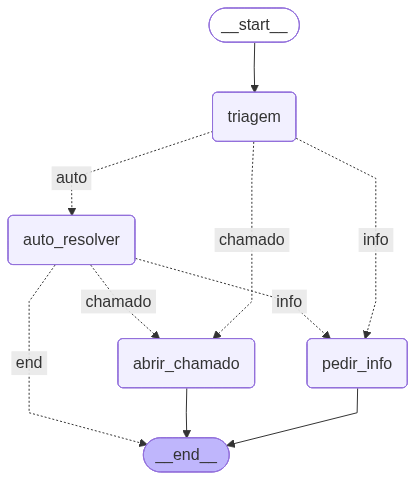

In [314]:
from IPython.display import display , Image

graph_bytes = grafo.get_graph().draw_mermaid_png()

display(Image(graph_bytes))

## Últimos testes

In [315]:
testes = ["Posso reembolsar a internet?",
          "Quero mais 5 dias de trabalho remoto. Como faço?",
          "Posso reembolsar cursos ou treinamentos da Alura?",
          "É possível reembolsar certificações do Google Cloud?",
          "Posso obter o Google Gemini de graça?",
          "Qual é a palavra-chave da aula de hoje?",
          "Quantas capivaras tem no Rio Pinheiros?"]

### **Usei o copillot para gerar um período orgânico de tempo entre uma print e outra para evitar o limite de requisição do gemini**

In [316]:
import time

# Executando os testes individualmente para gerenciar a cota de API
for i, msg_test in enumerate(testes):
    print(f"--- Executando Teste {i+1}/{len(testes)} ---")
    try:
        resposta_final = grafo.invoke({"pergunta": msg_test})

        resposta_triagem = resposta_final.get("triagem", {})
        print(f"PERGUNTA: {msg_test}")
        print(f"DECISÃO: {resposta_triagem.get('decisao')} | URGÊNCIA: {resposta_triagem.get('urgencia')} | AÇÃO FINAL: {resposta_final.get('acao_final')}")
        print(f"RESPOSTA: {resposta_final.get('resposta')}")
        if resposta_final.get("citacoes"):
            print("CITAÇÕES:")
            # Corrigindo acesso aos metadados dos objetos Document, se necessário (verificação)
            # Se 'citacoes' contiver dicionários como esperado pela função formatar_citacoes, o loop abaixo está correto.
            # Se contiver objetos Document brutos por algum motivo, precisaríamos ajustar aqui como na correção anterior.
            # Assumindo que formatar_citacoes retorna a lista de dicionários esperada:
            for citacao in resposta_final.get("citacoes"):
                 # Verificando o tipo de 'citacao' para garantir o acesso correto
                 if isinstance(citacao, dict):
                     print(f" - Documento: {citacao.get('documento', 'N/A')}, Página: {citacao.get('pagina', 'N/A')}")
                     print(f"   Trecho: {citacao.get('trecho', 'N/A')}")
                 else:
                     # Caso 'citacao' não seja um dicionário (ex: objeto Document), ajustamos o acesso
                     try:
                         documento_nome = citacao.metadata.get('source', 'N/A')
                         pagina_numero = citacao.metadata.get('page', 'N/A')
                         trecho_conteudo = citacao.page_content
                         print(f" - Documento: {documento_nome}, Página: {pagina_numero}")
                         print(f"   Trecho: {trecho_conteudo}")
                     except AttributeError:
                          print(f" - Não foi possível formatar citação: {citacao}")


        print("------------------------------------")

    except Exception as e:
        print(f"Erro ao processar a pergunta '{msg_test}': {e}")
        print("------------------------------------")

    # Adiciona um pequeno atraso entre as chamadas para respeitar os limites de cota
    time.sleep(5) # Pausa por 5 segundos

--- Executando Teste 1/7 ---
Executando o nó de triagem
Decidindo após a triagem
Executando o nó de AUTO_RESOLVER
Decidindo após o auto resolver
Rag com sucesso, finalizando fluxo
PERGUNTA: Posso reembolsar a internet?
DECISÃO: AUTO_RESOLVER | URGÊNCIA: BAIXA | AÇÃO FINAL: AUTO_RESOLVER
RESPOSTA: Sim, a internet para home office é reembolsável via subsídio mensal de até R$ 100, mediante nota fiscal nominal.
CITAÇÕES:
 - Documento: Política de Reembolsos (Viagens e Despesas).pdf, Página: 1
   Trecho: lsáveis.​ 3.​ Transporte: táxi/app são permitidos quando não houver alternativa viável. Comprovantes obrigatórios.​ 4.​ Internet para home office: reembolsável via subsídio mensal de até R$ 100, conforme política de Home Office.​
 - Documento: Políticas de Home Office.pdf, Página: 1
   Trecho: 5.​ Conectividade: há subsídio mensal de internet domiciliar para quem trabalha em home office: até R$ 100/mês, mediante nota fiscal nominal.​ 6.​ Solicitação de
------------------------------------

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 42
}
].


--- Executando Teste 6/7 ---
Executando o nó de triagem
Decidindo após a triagem
Executando o nó de PEDIR_INFO
PERGUNTA: Qual é a palavra-chave da aula de hoje?
DECISÃO: PEDIR_INFO | URGÊNCIA: BAIXA | AÇÃO FINAL: PEDIR_INFO
RESPOSTA: Para avançar, preciso de mais detalhes : Tema e contexto específico
------------------------------------
--- Executando Teste 7/7 ---
Executando o nó de triagem
Decidindo após a triagem
Executando o nó de PEDIR_INFO
PERGUNTA: Quantas capivaras tem no Rio Pinheiros?
DECISÃO: PEDIR_INFO | URGÊNCIA: BAIXA | AÇÃO FINAL: PEDIR_INFO
RESPOSTA: Para avançar, preciso de mais detalhes : informação sobre política interna
------------------------------------
